In [7]:
import pandas as pd
from sklearn.datasets import load_iris
import seaborn as sns
import sqlite3
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from ydata_profiling import ProfileReport

def create_connection(db_file, delete_db=False):
    import os
    if delete_db and os.path.exists(db_file):
        os.remove(db_file)

    conn = None
    try:
        conn = sqlite3.connect(db_file)
        conn.execute("PRAGMA foreign_keys = 1")
    except Exception as e:
        print(e)

    return conn


def create_table(conn, create_table_sql, drop_table_name=None):
    if drop_table_name: # You can optionally pass drop_table_name to drop the table. 
        try:
            c = conn.cursor()
            c.execute("""DROP TABLE IF EXISTS %s""" % (drop_table_name))
        except Exception as e:
            print(e)
    
    try:
        c = conn.cursor()
        c.execute(create_table_sql)
    except Exception as e:
        print(e)
        
def execute_sql_statement(sql_statement, conn):
    cur = conn.cursor()
    cur.execute(sql_statement)

    rows = cur.fetchall()

    return rows

db_name = 'Iris_Normalized.db'

In [12]:
import os

os.environ["MLFLOW_TRACKING_USERNAME"] = "Vedclove"
os.environ["MLFLOW_TRACKING_PASSWORD"] = "77a640deb2eb45d41fb235730a77f1a40b0f37a2"


In [24]:
import mlflow

mlflow.set_tracking_uri("https://dagshub.com/Vedclove/Iris-Flower-Classification.mlflow")

# List experiments to check connectivity
print(mlflow.list_experiments())


AttributeError: module 'mlflow' has no attribute 'list_experiments'

In [19]:
import mlflow
print(mlflow.__version__)


2.19.0


In [23]:
import logging

logging.basicConfig(level=logging.DEBUG)

from mlflow.tracking import MlflowClient
client = MlflowClient()
print(client.list_experiments())


AttributeError: 'MlflowClient' object has no attribute 'list_experiments'

In [22]:
from mlflow.tracking import MlflowClient

client = MlflowClient()
experiments = client.search_experiments()

# Print experiment details
for exp in experiments:
    print(f"Name: {exp.name}, ID: {exp.experiment_id}")



DEBUG:urllib3.connectionpool:https://dagshub.com:443 "POST /Vedclove/Iris-Flower-Classification.mlflow/api/2.0/mlflow/experiments/search HTTP/11" 200 None


Name: Default, ID: 0


In [6]:
import dagshub
dagshub.init(repo_owner='Vedclove', repo_name='Iris-Flower-Classification', mlflow=True)

import mlflow
with mlflow.start_run():
  mlflow.log_param('parameter name', 'value')
  mlflow.log_metric('metric name', 1)

ValueError: time data '2025-01-17T05:29Z' does not match format '%Y-%m-%dT%H:%M:%S.%fZ'

## Normalize Data

In [3]:
def read_csv(filename):
    flower_data = []
    flower_metric = []
    with open(filename, 'r') as file:
        lines = file.readlines()
    
    for line in lines:
        flower_metric.append(line.strip().split(',')[0:5])

    for line in lines:
        flower_data.append(line.strip().split(',')[0:6:5])
    
    return (flower_metric, flower_data)

flower_metric, flower_data = read_csv('Iris.csv')

In [4]:
flower_data[0:5]

[['Id', 'Species'],
 ['1', 'Iris-setosa'],
 ['2', 'Iris-setosa'],
 ['3', 'Iris-setosa'],
 ['4', 'Iris-setosa']]

In [5]:
flower_metric[0:5]

[['Id', 'SepalLengthCm', 'SepalWidthCm', 'PetalLengthCm', 'PetalWidthCm'],
 ['1', '5.1', '3.5', '1.4', '0.2'],
 ['2', '4.9', '3.0', '1.4', '0.2'],
 ['3', '4.7', '3.2', '1.3', '0.2'],
 ['4', '4.6', '3.1', '1.5', '0.2']]

### Table 1 - Flower Attribute Info

In [6]:
conn = create_connection(db_name)
cur = conn.cursor()
sql_create_table_flr_attr = ''' CREATE TABLE IF NOT EXISTS [FlowerAttributes] (
                                ID INTEGER NOT NULL PRIMARY KEY,
                                SepalLengthCm FLOAT NOT NULL,
                                SepalWidthCm FLOAT NOT NULL,
                                PetalLengthCm FLOAT NOT NULL,
                                PetalWidthCm FLOAT NOT NULL);
                                '''

create_table(conn,sql_create_table_flr_attr, True)

In [7]:
conn = create_connection(db_name)
cur = conn.cursor()
flr_attr_sql_insert = ''' INSERT OR IGNORE INTO FlowerAttributes (
                          SepalLengthCm, SepalWidthCm, PetalLengthCm, PetalWidthCm) VALUES (?,?,?,?);
                        '''

flower_attribute = []

for flower in flower_metric[1:]:
  sepal_len = flower[0]
  sepal_wid = flower[1]
  petal_len = flower[2]
  petal_wid = flower[3]
  flower_attribute.append((sepal_len,sepal_wid,petal_len, petal_wid))

cur.executemany(flr_attr_sql_insert, flower_attribute)
conn.commit()
conn.close()

In [8]:
conn = create_connection(db_name)
sql = ''' SELECT * FROM FlowerAttributes '''
pd.read_sql_query(sql,conn)

,ID,SepalLengthCm,SepalWidthCm,PetalLengthCm,PetalWidthCm
0,1,1.0,5.1,3.5,1.4
1,2,2.0,4.9,3.0,1.4
2,3,3.0,4.7,3.2,1.3
3,4,4.0,4.6,3.1,1.5
4,5,5.0,5.0,3.6,1.4
...,...,...,...,...,...
445,446,146.0,6.7,3.0,5.2
446,447,147.0,6.3,2.5,5.0
447,448,148.0,6.5,3.0,5.2
448,449,149.0,6.2,3.4,5.4


### Table 2 - Flower Name

In [9]:
conn = create_connection(db_name)
cur = conn.cursor()
sql_create_table_flr_attr = ''' CREATE TABLE IF NOT EXISTS [FlowerNames] (
                                ID INTEGER NOT NULL PRIMARY KEY,
                                Species TEXT NOT NULL);
                                '''

create_table(conn,sql_create_table_flr_attr, True)

In [10]:
conn = create_connection(db_name)
cur = conn.cursor()
flr_attr_sql_insert = ''' INSERT INTO FlowerNames (
                          Species) VALUES (?);
                        '''

flower_species = []

for flower in flower_data[1:]:
  species_name = flower[1]
  flower_species.append((species_name,))

cur.executemany(flr_attr_sql_insert, flower_species)
conn.commit()
conn.close()

In [11]:
conn = create_connection(db_name)
sql = ''' SELECT * FROM FlowerNames '''
sql_drop = ''' DROP TABLE FlowerNames '''
#execute_sql_statement(sql_drop,conn)
pd.read_sql_query(sql,conn)

,ID,Species
0,1,Iris-setosa
1,2,Iris-setosa
2,3,Iris-setosa
3,4,Iris-setosa
4,5,Iris-setosa
...,...,...
445,446,Iris-virginica
446,447,Iris-virginica
447,448,Iris-virginica
448,449,Iris-virginica


### Extract Data into DataFrame

In [12]:
conn = create_connection(db_name)
sql = ''' SELECT FA.ID, FA.SepalLengthCm, FA.SepalWidthCm, FA.PetalLengthCm, FA.PetalWidthCm, FN.Species FROM FlowerAttributes as FA
        INNER JOIN FlowerNames as FN
        ON FA.ID = FN.ID; '''

df = pd.read_sql_query(sql, conn)

In [13]:
df

,ID,SepalLengthCm,SepalWidthCm,PetalLengthCm,PetalWidthCm,Species
0,1,1.0,5.1,3.5,1.4,Iris-setosa
1,2,2.0,4.9,3.0,1.4,Iris-setosa
2,3,3.0,4.7,3.2,1.3,Iris-setosa
3,4,4.0,4.6,3.1,1.5,Iris-setosa
4,5,5.0,5.0,3.6,1.4,Iris-setosa
...,...,...,...,...,...,...
445,446,146.0,6.7,3.0,5.2,Iris-virginica
446,447,147.0,6.3,2.5,5.0,Iris-virginica
447,448,148.0,6.5,3.0,5.2,Iris-virginica
448,449,149.0,6.2,3.4,5.4,Iris-virginica


## Stratification and Data Train/Test split

### Exploring data and Define Train/Test data

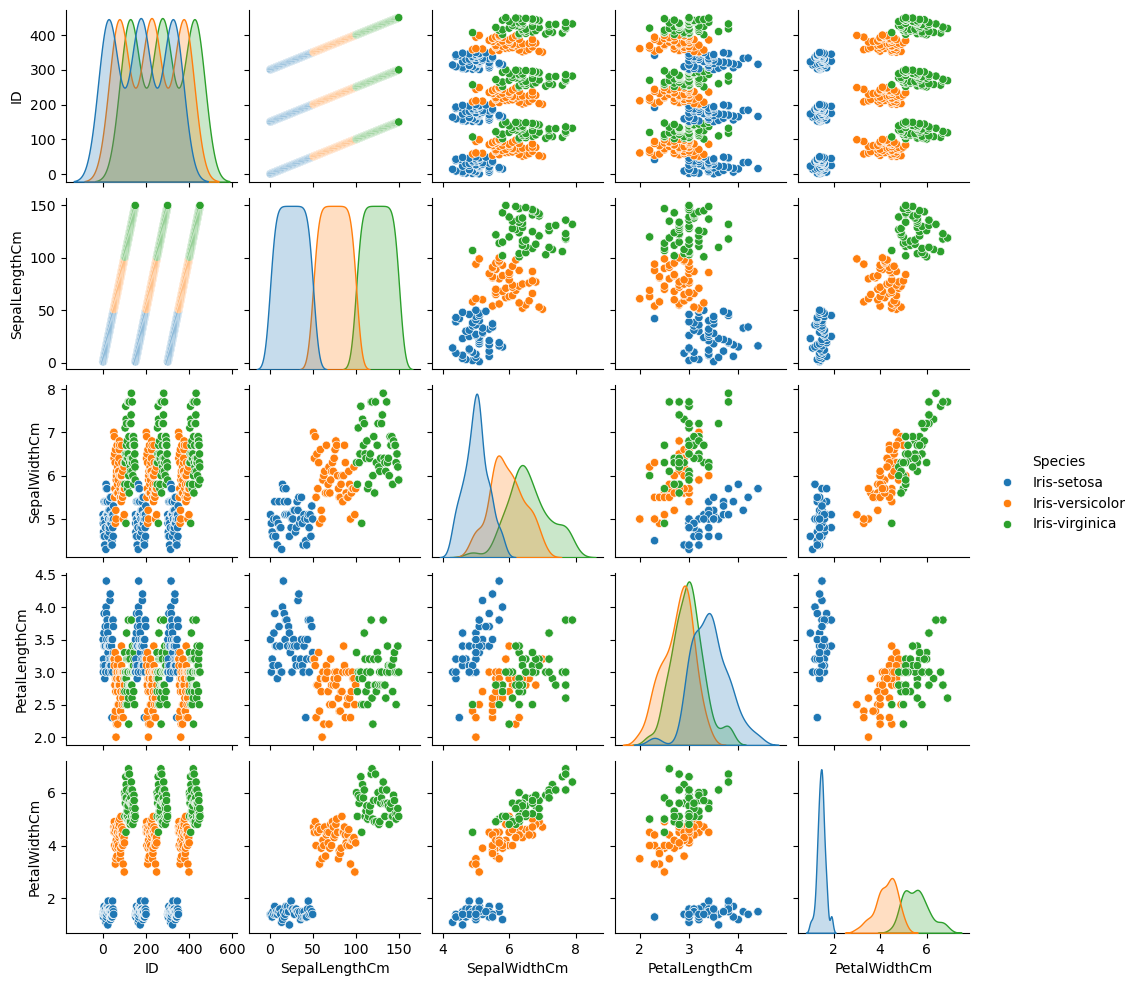

In [14]:
sns.pairplot(df, hue='Species', height=2)
plt.show()

In [15]:
# Checking distribution of the species over the entire dataset
species_counts = df['Species'].value_counts()
print("Species distribution in the entire dataset:")
print(species_counts)

Species distribution in the entire dataset:
Species
Iris-setosa        150
Iris-versicolor    150
Iris-virginica     150
Name: count, dtype: int64


In [16]:
X = df.drop(columns=['Species'])
y = df['Species']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Check the distribution in train and test sets
train_distribution = pd.Series(y_train).value_counts()
test_distribution = pd.Series(y_test).value_counts()

print("\nSpecies distribution in the TRAINING set:")
print(train_distribution)

print("\nSpecies distribution in the TESTING set:")
print(test_distribution)


Species distribution in the TRAINING set:
Species
Iris-versicolor    120
Iris-virginica     120
Iris-setosa        120
Name: count, dtype: int64

Species distribution in the TESTING set:
Species
Iris-virginica     30
Iris-setosa        30
Iris-versicolor    30
Name: count, dtype: int64


### Data Exploration using yprofile and correlation matrix

In [17]:
# Generate a profile report using ydata-profiling
profile = ProfileReport(df, title="Iris Dataset Profiling Report", explorative=True)
profile.to_notebook_iframe()  # Display the report in a notebook (or save it to HTML if needed)

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

In [18]:
# Example if species is a string column
df['Species'] = df['Species'].astype('category').cat.codes

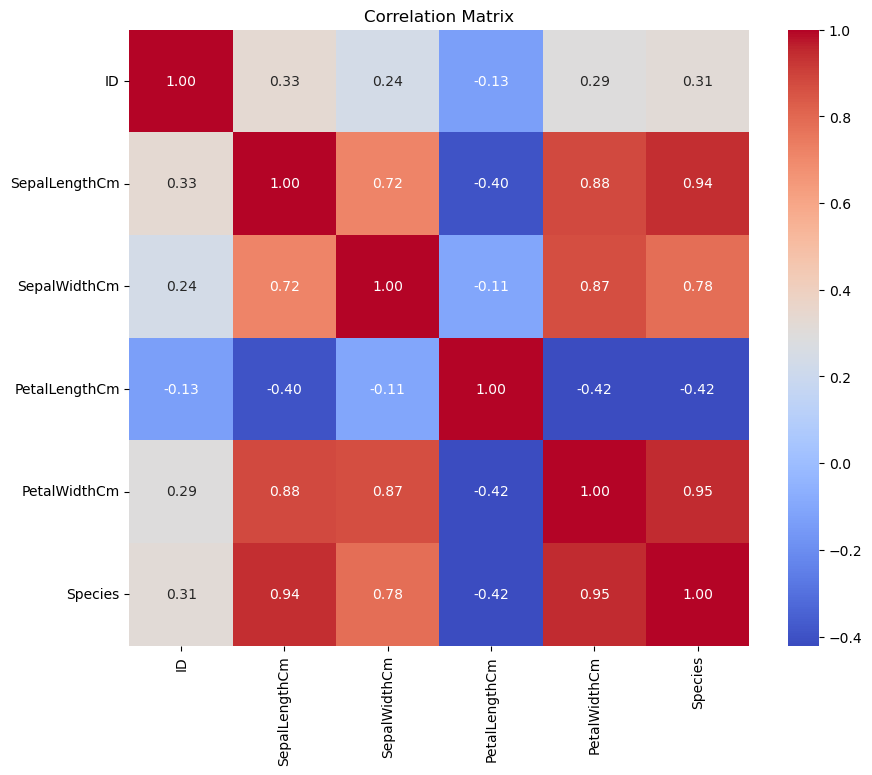

In [19]:
 # Display the correlation matrix
correlation_matrix = df.corr()
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f')
plt.title("Correlation Matrix")
plt.show()

In [20]:
# Check for missing values
missing_values = df.isnull().sum()
print("\nMissing Values:")
print(missing_values)

# Check for capped values (e.g., outliers or unusual distributions)
print("\nSummary Statistics:")
print(df.describe())


Missing Values:
ID               0
SepalLengthCm    0
SepalWidthCm     0
PetalLengthCm    0
PetalWidthCm     0
Species          0
dtype: int64

Summary Statistics:
               ID  SepalLengthCm  SepalWidthCm  PetalLengthCm  PetalWidthCm  \
count  450.000000       450.0000    450.000000     450.000000    450.000000   
mean   225.500000        75.5000      5.843333       3.054000      3.758667   
std    130.048068        43.3485      0.826220       0.432628      1.760486   
min      1.000000         1.0000      4.300000       2.000000      1.000000   
25%    113.250000        38.0000      5.100000       2.800000      1.600000   
50%    225.500000        75.5000      5.800000       3.000000      4.350000   
75%    337.750000       113.0000      6.400000       3.300000      5.100000   
max    450.000000       150.0000      7.900000       4.400000      6.900000   

          Species  
count  450.000000  
mean     1.000000  
std      0.817405  
min      0.000000  
25%      0.000000  
50%

### Preprocessing